In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [3]:
forces = np.genfromtxt('../data/MB-pol/16.forces', delimiter = ',').reshape(-1,16,3,3)

In [22]:
basepath_feat = '../data/PBE/szp/basis_nocore_nn.json_processed/'
basepath_tar = '../data/PBE/szp/'
revpath_tar = '../data/PBE/dz_custom/'

# systems = ['monomers','dimers','trimers']
systems = ['16p16']
mono_offset = 0
n_mol = [3,2,1]
filters = [([True,True] + [False]*10)*3000]
for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
# # filters = [np.genfromtxt('../publication/data/filters/{}.filter'.format(s), dtype =bool) for s in systems]
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'o')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(8192, 18)


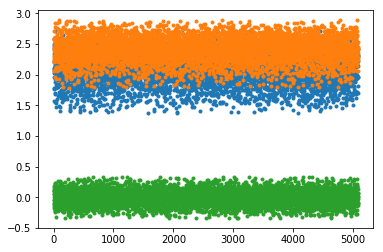

In [23]:
plot(nn.y_train,ls = '', marker = '.')

In [24]:
nn.nodes_per_layer = 16

In [25]:
nn.train(early_stopping=True, b=1e-8, restart = True)

--------Epoch = 0----------
Training loss || Validation loss
     1.715606 ||      1.720369
--------Epoch = 500----------
Training loss || Validation loss
     0.100175 ||      0.102813
--------Epoch = 1000----------
Training loss || Validation loss
     0.096566 ||      0.099152
--------Epoch = 1500----------
Training loss || Validation loss
     0.094871 ||      0.097759


======== Evaluation on test set =============
              RMSE =  0.0980
              MAE = 0.0768
              Max. abs. error = 0.4144


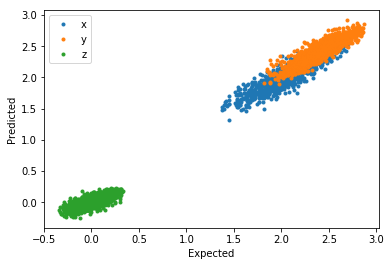

{'rmse': 0.09798873385962037,
 'mae': 0.07683862203481401,
 'max': 0.41442511426633644}

In [26]:
nn.evaluate(plot=True, on='valid')

======== Evaluation on test set =============
              RMSE =  0.1100
              MAE = 0.0864
              Max. abs. error = 0.4783


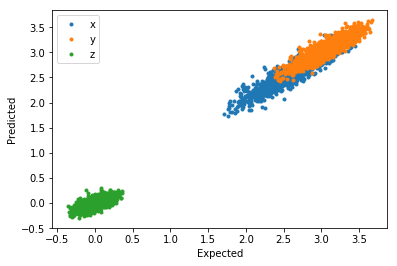

{'rmse': 0.11004925742334068,
 'mae': 0.0864140407626144,
 'max': 0.47828370739927806}

In [18]:
nn.evaluate(plot=True, on='valid')

In [27]:
nn.save_all('../../elf_models/mlcf_master/16p16/pbeszp_pbedzp/')